# Exercise: Classification I

In this exercise session, you will be training a logistic regression model to classify movie review text into positive and negative reviews. You will be using a bag-of-words approach, where the features are the TF-IDF scores of the tokens in the review.

# 1. Load the libraries

You will need to have installed:

- pandas
- numpy
- datasets
- sklearn
- wordcloud and matplotlib (optional)

It is good practice to have all the imports at the top of the notebook.

In [2]:
import pandas as pd
import numpy as np
from datasets import load_dataset, logging
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import nltk
nltk.download('stopwords') #optional, for stopword removal preprocessing
nltk.download('punkt') #optional, for stopword removal preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# enabling inline plots in Jupyter
%matplotlib inline
# disabling verbose messages from dataset library
logging.set_verbosity_error()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 2. Load the *rotten_tomatoes* data set

This is a data set of short snippets from movie reviews on Rotten Tomatoes, along with whether the review gave the movie a positive ("fresh") or negative ("rotten") rating.

1. Have a look at the [documentation](https://huggingface.co/datasets/rotten_tomatoes) of the data set on HuggingFace
2. Load the dataset (train, validation and test splits) from the huggingface library.
3. Print some review to have an idea of what kind of data this is.

You can also browse all HF datasets visually online at [huggingface datasets](https://huggingface.co/datasets).

In [3]:
# load the 2-class sentiment classification model from rotten_tomatoes
train = load_dataset('rotten_tomatoes', 'sentiment', split='train')
val = load_dataset('rotten_tomatoes', 'sentiment', split='validation')
test = load_dataset('rotten_tomatoes', 'sentiment', split='test')

print(train.description)
print(train[0:5])

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset rotten_tomatoes downloaded and prepared to C:/Users/chris/.cache/huggingface/datasets/rotten_tomatoes/sentiment/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46. Subsequent calls will reuse this data.
Movie Review Dataset.
This is a dataset of containing 5,331 positive and 5,331 negative processed
sentences from Rotten Tomatoes movie reviews. This data was first used in Bo
Pang and Lillian Lee, ``Seeing stars: Exploiting class relationships for
sentiment categorization with respect to rating scales.'', Proceedings of the
ACL, 2005.

{'text': ['the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson\'s expanded vision of j . r . r . tolkien\'s middle-earth .', 'effec

# 3. Vectorizing the texts with TF-IDF

1. Get the texts of the reviews and labels into separate lists for all the `rotten_tomatoes` data subsets
2. Turn the texts into numbers with TFIDF vectorizer from scikit-learn.

TF-IDF vectorizer documentation can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In [18]:
train_corpus = [x["text"] for x in train]
train_labels = [x["label"] for x in train]

In [19]:
# vectorizing the training part of the corpus
vectorizer = TfidfVectorizer() # the default ngram range is (1,1)

train_features = vectorizer.fit_transform(train_corpus)
feature_names = vectorizer.get_feature_names_out()
sparse_array = train_features.toarray()

print(train_corpus[0])
print(sparse_array[0])
print(feature_names)

the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .
[0. 0. 0. ... 0. 0. 0.]
['00' '007' '10' ... 'últimos' 'única' 'único']


In [20]:
# vectorizing the test and validation part of the corpus

# in this case we're calling .transform() rather than fit_transform(),
# because this way the new vocabulary is not learned and we will have
# a better idea of performance on unseen data

val_corpus = [x["text"] for x in val]
val_features = vectorizer.transform(val_corpus)
val_labels = [x["label"] for x in val]

test_corpus = [x["text"] for x in test]
test_features = vectorizer.transform(test_corpus)
test_labels = [x["label"] for x in test]


# 4. Exploratory analysis

1. How many classes does this data have? Are the classes balanced?
2. What are the top 10 frequent words in all the reviews?

Hint: if you use sklearn CountVectorizer and are running out of memory, you can limit how many words to compute frequencies for.

In [10]:
# basic class statistics
all_labels = train_labels+val_labels+test_labels
print(f"The full dataset contains {len(all_labels)} instances, of which {all_labels.count(0)} are negative, and {all_labels.count(1)} are positive.")

The full dataset contains 10662 instances, of which 5331 are negative, and 5331 are positive.


In [11]:
# top words
full_corpus = train_corpus+val_corpus+test_corpus
full_corpus_string = " ".join(full_corpus)

# limiting the maximum number of words to compute frequency for, to save compute
count_vectorizer = CountVectorizer(ngram_range=(1,1), max_features=10000)
count_matrix = count_vectorizer.fit_transform([full_corpus_string])

counts = pd.DataFrame(count_matrix.toarray(),
                      columns=count_vectorizer.get_feature_names_out())

# getting top 10 most common words
counts.T.sort_values(by=0, ascending=False).head(10)

,0
the,10209
and,6264
of,6148
to,4275
it,3435
is,3384
in,2675
that,2658
as,1808
but,1641


# 5. Logistic Regression

1. Create the classifier and train it on the train set. If you find that it doesn't converge, try increasing the number of iterations (`max_iter` parameter), e.g. to 1500. Documentation for logistic regression can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
2. Make predictions on the validation set (leave the test set aside for now)
3. Use the accuracy metric to compare the predicted labels to the ground truth labels you have from the original data. The documentation is [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html).
4. Optional bonus task: scikit learn has a very useful [dummy classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). If your classifier were always simply predicting the majority class, how well would it do?

In [12]:
# Create logistic regression object
lr = LogisticRegression(max_iter=1500)

# Train the model using the training sets
lr.fit(train_features, train_labels)

# Make predictions using the testing set
val_pred = lr.predict(val_features)


In [13]:
# compare the predictions to the gold labels
print("Accuracy for LR with default parameters:", accuracy_score(val_labels, val_pred))


Accuracy for LR with default parameters: 0.7514071294559099


In [14]:
#Dummy Classifier - a "naive baseline" that simply predicts the majority class
from sklearn.dummy import DummyClassifier
majority_class = DummyClassifier(strategy= 'most_frequent').fit(train_features,train_labels)
val_pred_majority = majority_class.predict(val_features)

print("Majority baseline accuracy:", accuracy_score(val_labels, val_pred_majority))

Majority baseline accuracy: 0.5


# 6. Testing on your own data!

1. Find 10-20 reviews outside of this dataset. You can pick any reviews you like, from rottentomatoes.com or ones you write yourself.
2. Put them into a spreadsheet and either manually annotate them with negative or positive sentiment, or use the labels provided on rottentomatoes.com. Make sure the columns are named "text" and "label" and the labels are consistent with the `rotten_tomatoes` markup scheme (1=positive, 0=negative).
3. Save this file as a .csv file, load it into your notebook, convert the text to TF-IDF scores.
4. Use this small dataset as a test dataset for the logistic regression classifier trained on the `rotten_tomatoes` data. Is your classifier doing better or worse than on the validation data?

In [24]:
mydata = pd.read_csv("classification1_annotation.csv")
mydata.head()

,text,label
0,Among the many errors of The Super Mario Bros....,0
1,It is the laziest possible version of a Mario ...,0
2,The sneaky surprise here is Jack Black playing...,1
3,The whole package is a deranged mishmash of ov...,0
4,A frantic Easter egg hunt of a film that does ...,0


In [17]:
mytest_corpus= list(mydata["text"])
mytest_labels = list(mydata["label"])
mytest_features = vectorizer.transform(mytest_corpus)
                     
mytest_pred = lr.predict(mytest_features)
print("Accuracy for LR on the new test data:", accuracy_score(mytest_labels, mytest_pred))

Accuracy for LR on the new test data: 0.6666666666666666


# 7. Does pre-processing make a difference?

Everything you've done so far was just considering the raw text of the reviews. Let us try to add pre-processing.

1. What preprocessing do you think could help the classifier? Why do you think so?
2. Implement this pre-processing and re-vectorize the reviews.
3. Re-run the classifier. Did the accuracy improve? Why do you think it improved (or didn't)?

In [25]:

#as an example, we will try stopword removal here

#get English stopwords
stop_words = set(stopwords.words('english'))

#function to tokenize a text, remove stopwords and join
#the tokens back together with spaces in between
def stop_remover(x):
    #tokenizes
    word_tokens = word_tokenize(x)
    #converts the words in word_tokens to lower case and then checks whether 
    #they are present in stop_words or not
    filtered_tokens = [w for w in word_tokens if not w.lower() in stop_words]
    #rejoins
    filtered_sentence = " ".join(filtered_tokens)
    return(filtered_sentence)

#do stopword removal on the train and validation corpus
train_corpus_nostop = [stop_remover(sent) for sent in train_corpus]
val_corpus_nostop = [stop_remover(sent) for sent in val_corpus]


In [26]:
#re-vectorizing
vectorizer = TfidfVectorizer() # the default ngram range is (1,1)
tokenized_train_features = vectorizer.fit_transform(train_corpus_nostop)
tokenized_val_features = vectorizer.transform(val_corpus_nostop)

In [27]:
#re-training the model
tokenized_lr = LogisticRegression(max_iter=1500)
tokenized_lr.fit(tokenized_train_features, train_labels)
tokenized_val_pred = tokenized_lr.predict(tokenized_val_features)
print("Accuracy for LR with stopword-removed data:", accuracy_score(val_labels, tokenized_val_pred))

Accuracy for LR with stopword-removed data: 0.7636022514071295


So - in this case stopword removal seems to make things a bit better, although not by much! Did you have more luck with some other pipeline?

Pre-processing is art rather than science. Cleaner data is generally better, but the same tool may work great on one part of dataset and fail on another one, that is different in some way. If you're particularly interested in some specific group of words, do make sure that that pre-processing does not distort them in some way. And whatever you do - document it, down to the pre-processing library version.

# 8. Bonus: visualize the reviews with a word cloud

Wordcloud is a nice little library to visualize text. The only required argument is the text from which the wordcloud should be generated. Removing punctuation, lowercasing and stripping English stopwords happens automatically.

- [reference](https://github.com/amueller/word_cloud/blob/master/examples/simple.py)
- [tutorial](https://www.datacamp.com/community/tutorials/wordcloud-python)

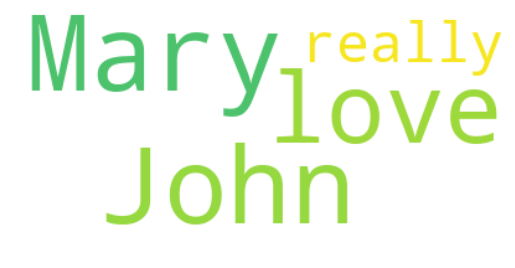

In [27]:
#basic usage:
wordcloud = WordCloud(background_color="white", width=400).generate(
    "John loves Mary and Mary doesn't really love John")

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

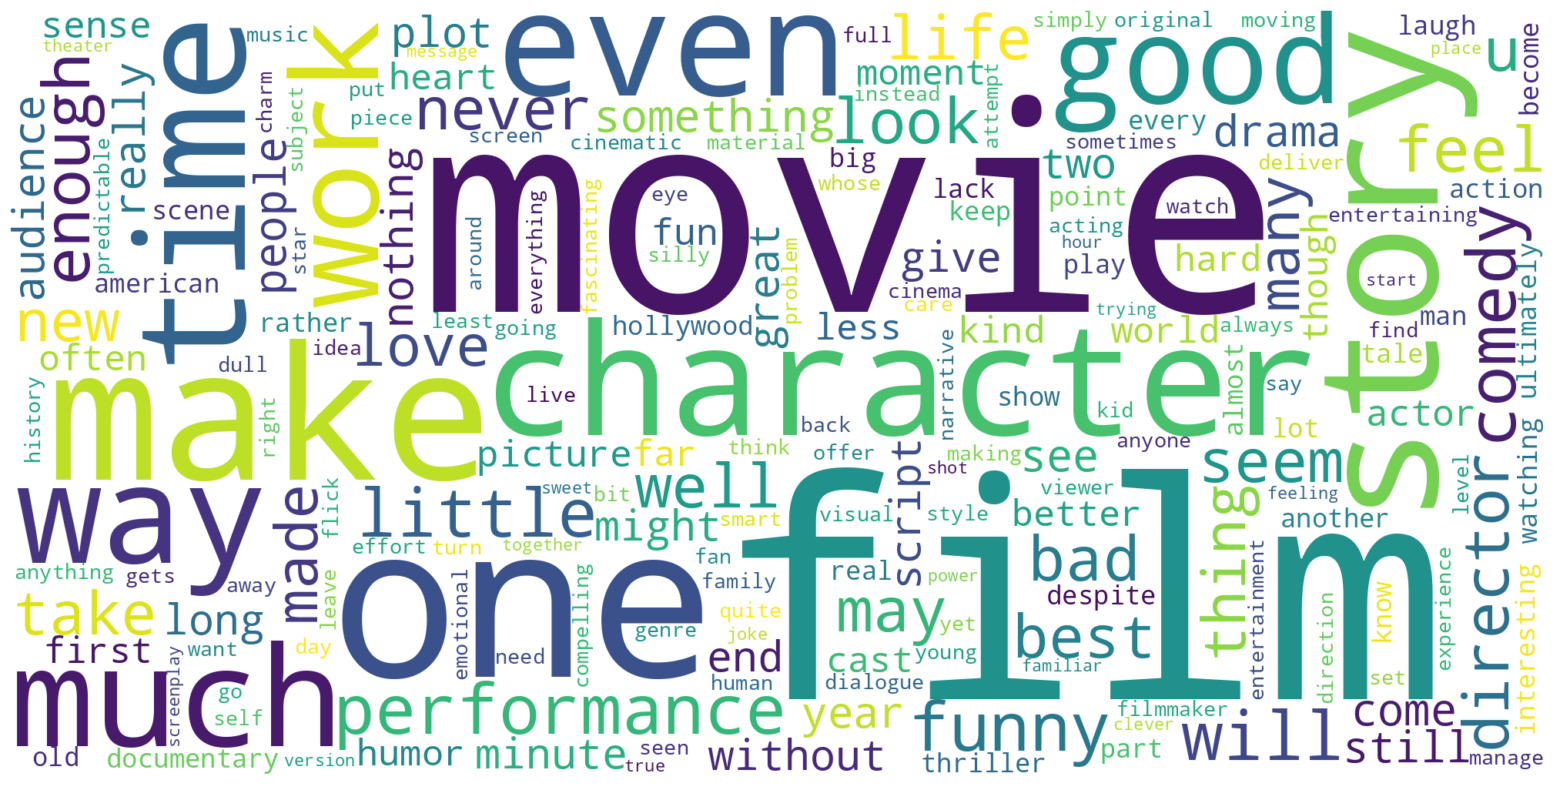

In [28]:
# the wordcloud expects text, so we need to turn all of our text to a single string
train_text = " ".join(train_corpus)
# generating the cloud. The corpus is large, so will need a larger canvas to fit in more words
wordcloud = WordCloud(background_color="white", width=2000, height=1000).generate(train_text)

# Display the generated image:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()